# On Building a Deep Learning Dataset Using Social Media Images and Training a Model to Detect Street Art

Here’s a quick overview of our process:
        

1. Build a street art deep learning image dataset using hashtag results for “#streetart”.
2. Use the images to build a model that will predict if images contain street art.
3. Clean the dataset and retrain the model for improved results.

In [1]:
import matplotlib
matplotlib.use("Agg")

from imutils import build_montages
from imutils import paths
from keras.models import load_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from pyimagesearch.resnet import ResNet
from sklearn.metrics import classification_report
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

Using TensorFlow backend.


In [2]:
PATH = '/floyd/input/streetart'

# initialize the number of training epochs and batch size
DATASET = '/floyd/input/streetart'
NUM_EPOCHS = 20
BS = 32
IMAGE_NAME = 'plot.png'
MODEL_NAME = 'streetart.model'
MONTAGE_FILENAME = 'streetart_montage.png'

# initialize our list of results
results = []

# derive the path to the directories containing the training,
# validation, and testing splits, respectively
TRAIN_PATH = os.path.sep.join([DATASET, "training"])
VAL_PATH = os.path.sep.join([DATASET, "validation"])
TEST_PATH = os.path.sep.join([DATASET, "testing"])

imagePaths = list(paths.list_images(TEST_PATH))
random.shuffle(imagePaths)
imagePaths = imagePaths[:50]


# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

In [3]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=32)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 4511 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
Found 1254 images belonging to 2 classes.


In [4]:
# initialize our Keras implementation of ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (2, 2, 3),
	(32, 64, 128, 256), reg=0.0005)
opt = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train our Keras model
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS)

Epoch 1/20
140/140 [==============================] - 216s 2s/step - loss: 0.8415 - acc: 0.6683 - val_loss: 0.7007 - val_acc: 0.7688
Epoch 2/20
140/140 [==============================] - 201s 1s/step - loss: 0.7419 - acc: 0.7133 - val_loss: 0.6995 - val_acc: 0.7377
Epoch 3/20
140/140 [==============================] - 201s 1s/step - loss: 0.7104 - acc: 0.7330 - val_loss: 0.6850 - val_acc: 0.7313
Epoch 4/20
140/140 [==============================] - 200s 1s/step - loss: 0.6895 - acc: 0.7374 - val_loss: 0.7334 - val_acc: 0.7015
Epoch 5/20
140/140 [==============================] - 199s 1s/step - loss: 0.6735 - acc: 0.7437 - val_loss: 0.6394 - val_acc: 0.7676
Epoch 6/20
140/140 [==============================] - 199s 1s/step - loss: 0.6683 - acc: 0.7484 - val_loss: 0.6939 - val_acc: 0.7356
Epoch 7/20
140/140 [==============================] - 199s 1s/step - loss: 0.6583 - acc: 0.7537 - val_loss: 0.7341 - val_acc: 0.6908
Epoch 8/20
140/140 [==============================] - 200s 1s/step - 

In [ ]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BS) + 1)# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [6]:
print(predIdxs)

[1 0 0 ... 1 0 1]


In [7]:

# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))

# save the network to disk
print("[INFO] serializing network to '{}'...".format(MODEL_NAME))
model.save(MODEL_NAME)

               precision    recall  f1-score   support

not_streetart       0.85      0.73      0.79       858
    streetart       0.55      0.73      0.63       396

    micro avg       0.73      0.73      0.73      1254
    macro avg       0.70      0.73      0.71      1254
 weighted avg       0.76      0.73      0.74      1254

[INFO] serializing network to 'streetart.model'...


[INFO] evaluating model against test set...
[INFO] building image montage of results...


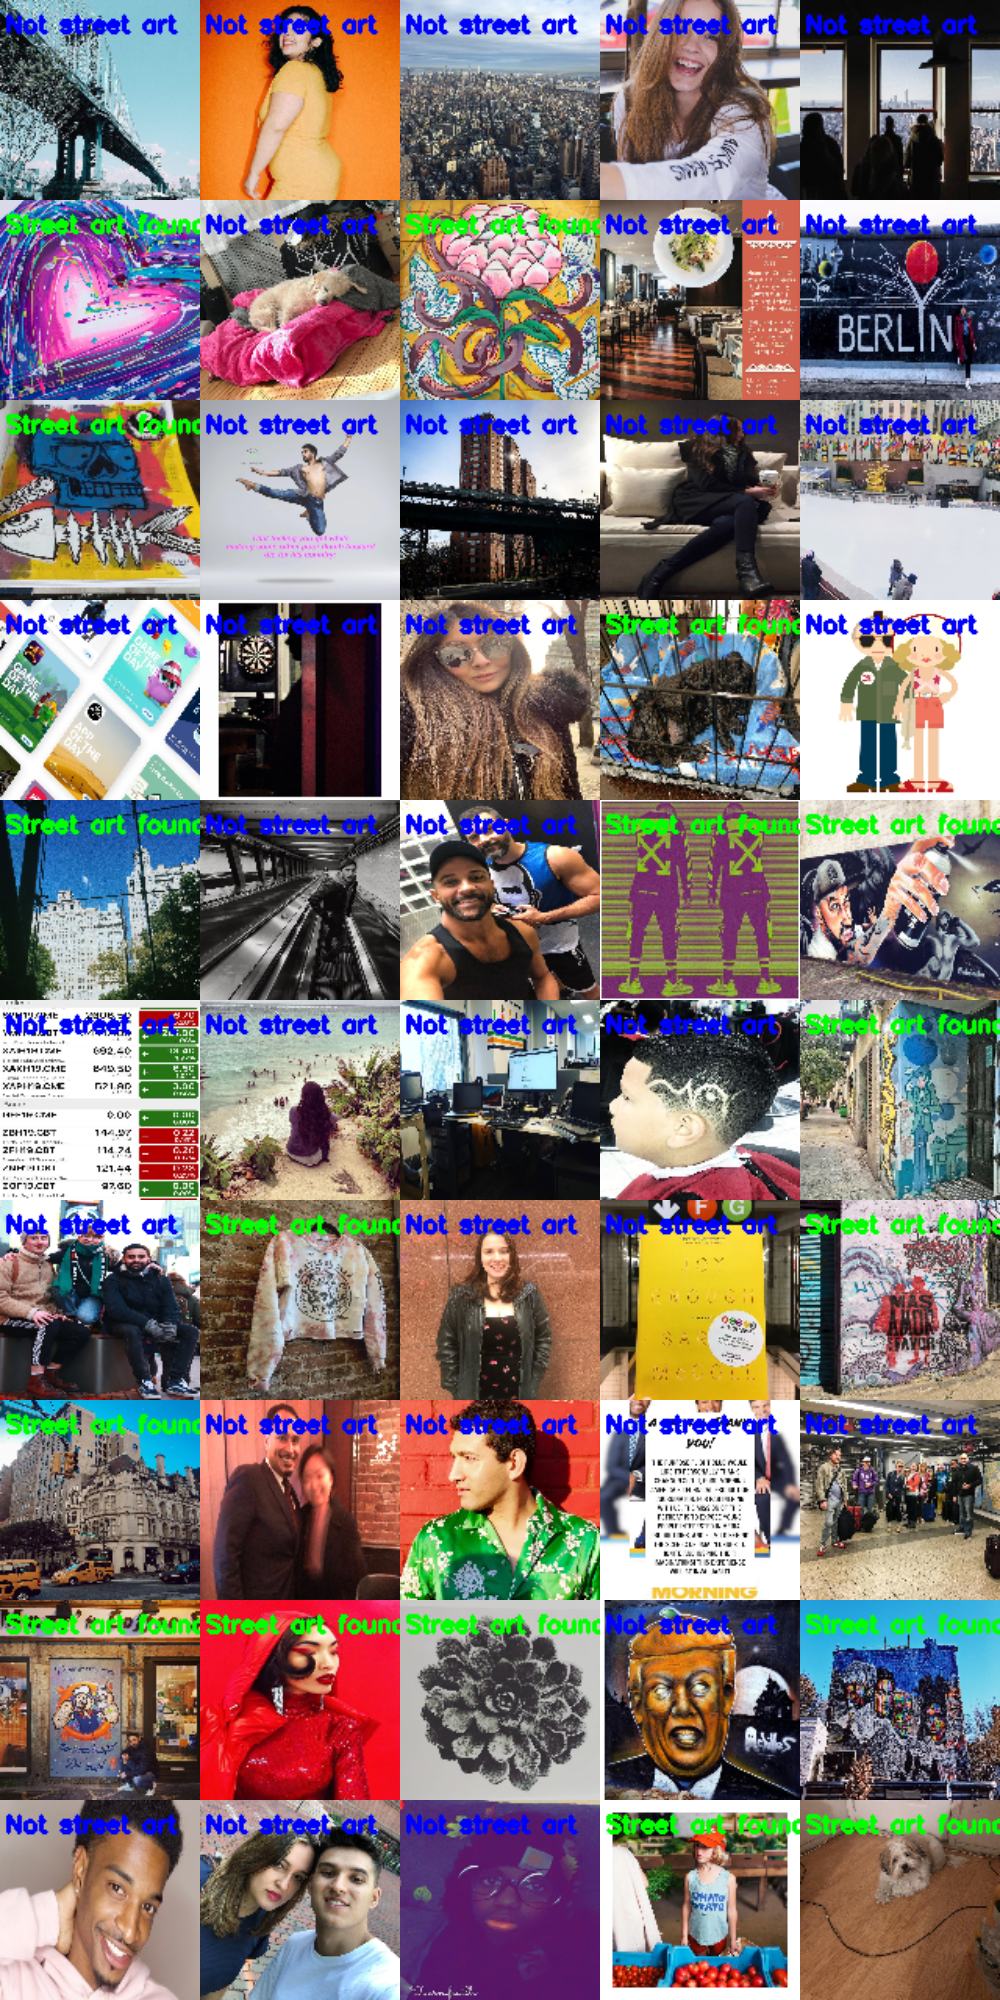

In [8]:
model = load_model(MODEL_NAME)

# loop over our sampled image paths
print("[INFO] evaluating model against test set...")
for p in imagePaths:
	# load our original input image
	orig = cv2.imread(p)

	# pre-process our image by converting it from BGR to RGB channel
	# ordering (since our Keras mdoel was trained on RGB ordering),
	# resize it to 64x64 pixels, and then scale the pixel intensities
	# to the range [0, 1]
	image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (64, 64))
	image = image.astype("float") / 255.0

	# order channel dimensions (channels-first or channels-last)
	# depending on our Keras backend, then add a batch dimension to
	# the image
	image = img_to_array(image)
	image = np.expand_dims(image, axis=0)

	# make predictions on the input image
	pred = model.predict(image)
	pred = pred.argmax(axis=1)[0]

	# an index of zero is the 'parasitized' label while an index of
	# one is the 'uninfected' label
	label = "Not street art" if pred == 0 else "Street art found"
	color = (255, 0, 0) if pred == 0 else (0, 255, 0)

	# resize our original input (so we can better visualize it) and
	# then draw the label on the image
	orig = cv2.resize(orig, (128, 128))
	cv2.putText(orig, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)

	# add the output image to our list of results
	results.append(orig)
print("[INFO] building image montage of results...")

# create a montage using 128x128 "tiles" with 4 rows and 4 columns
montage = build_montages(results, (200, 200), (5, 10))[0]
cv2.imwrite(MONTAGE_FILENAME, montage)

img = cv2.imread(MONTAGE_FILENAME)
img2 = img[:,:,::-1]
plt.imshow(img)

from IPython.display import Image
Image(filename=MONTAGE_FILENAME)